# Retrieval Optimization Techniques: Making Your RAG System Smarter

Welcome to this hands-on guide! We'll learn how to make your retrieval system much better at finding the right information. Think of it like upgrading from a basic search to a smart search that really understands what you're looking for.

## What We'll Cover
1. **Metadata Filtering** - Search with smart filters
2. **Contextual Retrieval** - Give chunks more context for better matching
3. **Outlier Exclusion** - Remove obviously bad results
4. **Hybrid Search** - Combine different search methods for better results

## Why This Matters
Regular retrieval systems often return irrelevant results or miss important information. These techniques fix those problems by being smarter about how we search and what we return.

## Setup: Installing What We Need

Let's install the tools we'll use. Think of these as our search engine building blocks.

In [ ]:
%pip install openai langchain langchain-openai langchain-community chromadb

## Import Libraries and Setup

Now let's import everything we need and set up our API key.

In [ ]:
import os
import chromadb
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.retrievers import BM25Retriever
from langchain.schema import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate

# Set your OpenAI API key
os.environ['OPENAI_API_KEY'] = '<your-api-key>'

## Creating Sample Data

Let's create some sample documents to work with. We'll use a mix of company documents and geographical information to demonstrate the techniques.

In [ ]:
# Sample documents with metadata
sample_documents = [
    {
        "content": "Our Q3 revenue increased by 15% compared to Q2, reaching $2.5 million. This growth was driven primarily by our new product line launch in July.",
        "metadata": {"type": "financial", "quarter": "Q3", "year": 2024, "department": "finance"}
    },
    {
        "content": "The new employee onboarding process includes a 3-day orientation program, HR documentation setup, and IT equipment assignment.",
        "metadata": {"type": "hr", "department": "human_resources", "year": 2024, "topic": "onboarding"}
    },
    {
        "content": "Our Python API supports REST endpoints for user authentication, data retrieval, and real-time notifications. Rate limiting is set to 1000 requests per hour.",
        "metadata": {"type": "technical", "language": "python", "department": "engineering", "year": 2024}
    },
    {
        "content": "Berlin is the capital and largest city of Germany, both by area and by population. Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.",
        "metadata": {"type": "geographical", "country": "Germany", "year": 2024, "topic": "cities"}
    },
    {
        "content": "Paris is the capital and most populous city of France. It is situated along the Seine River in the north-central part of the country. The city has a population of over 2.1 million residents within its administrative limits.",
        "metadata": {"type": "geographical", "country": "France", "year": 2024, "topic": "cities"}
    }
]

# Full document for contextual retrieval demonstration
full_document_text = """Berlin is the capital and largest city of Germany, both by area and by population.
Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.
The city is also one of the states of Germany and is the third smallest state in the country in terms of area.
Paris is the capital and most populous city of France.
It is situated along the Seine River in the north-central part of the country.
The city has a population of over 2.1 million residents within its administrative limits, making it one of Europe's major population centers."""

print(f"Created {len(sample_documents)} sample documents")
print("\nExample document:")
print(f"Content: {sample_documents[0]['content']}")
print(f"Metadata: {sample_documents[0]['metadata']}")

## Setting Up Our Basic Retrieval System

Let's create a basic retrieval system first, then we'll upgrade it step by step.

In [ ]:
# Initialize embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Create vector store directly with LangChain's Chroma wrapper
collection = Chroma(
    collection_name="company_docs",
    embedding_function=embeddings,
    persist_directory="./chroma_db"  # optional: for persistence
)

# Prepare documents
texts = [doc["content"] for doc in sample_documents]
metadatas = [doc["metadata"] for doc in sample_documents]

# Add documents using LangChain's interface
collection.add_texts(
    texts=texts,
    metadatas=metadatas
)

print("Basic retrieval system ready!")

## Technique 1: Metadata Filtering

Metadata filtering is like adding smart filters to your search. Instead of just searching through all documents, you can say "only show me financial documents from Q3" or "only technical documents from engineering".

### Why This Helps
Imagine you're asking about "revenue" - you probably want financial documents, not HR documents that mention "revenue targets for hiring". Metadata filtering makes sure you get the right type of content.

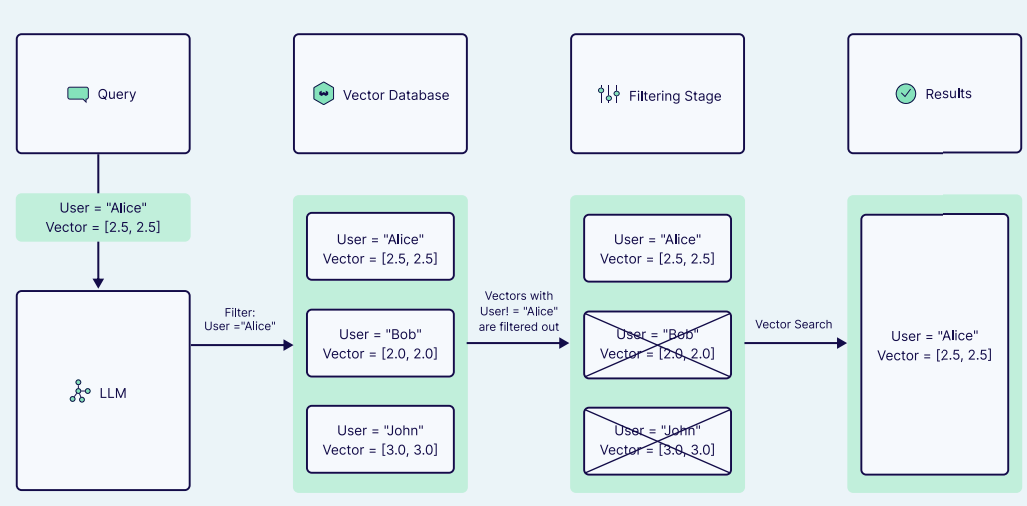

In [ ]:
# Initialize embeddings and collection
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

collection = Chroma(
    collection_name="company_docs",
    embedding_function=embeddings,
    persist_directory="./chroma_db"
)

def basic_search(query: str, n_results: int = 3):
    """Basic search without any filtering"""
    results = collection.similarity_search(
        query=query,
        k=n_results
    )
    return results

def filtered_search(query: str, metadata_filter: dict, n_results: int = 3):
    """Search with metadata filtering"""
    results = collection.similarity_search(
        query=query,
        k=n_results,
        filter=metadata_filter
    )
    return results

# Example: Let's search for "revenue" 
query = "What was our revenue performance?"

print("=== BASIC SEARCH (no filtering) ===")
basic_results = basic_search(query)
for i, doc in enumerate(basic_results):
    print(f"Result {i+1}: {doc.page_content[:100]}...")
    print(f"Type: {doc.metadata.get('type', 'unknown')}\n")

print("\n=== FILTERED SEARCH (only financial docs) ===")
financial_filter = {"type": "financial"}
filtered_results = filtered_search(query, financial_filter)
for i, doc in enumerate(filtered_results):
    print(f"Result {i+1}: {doc.page_content[:100]}...")
    print(f"Type: {doc.metadata.get('type', 'unknown')}\n")

## Technique 2: Contextual Retrieval

Regular chunks often lose important context. For example, a chunk might say "Revenue increased by 15%" but not mention it's about Q3 2024 or which company.

Contextual retrieval adds helpful context to each chunk before creating embeddings. It's like giving each piece of text a brief explanation of what document it came from.

### How It Works
1. Take each chunk
2. Add context about the document it came from
3. Create embeddings with this enriched content
4. Search becomes much more accurate!

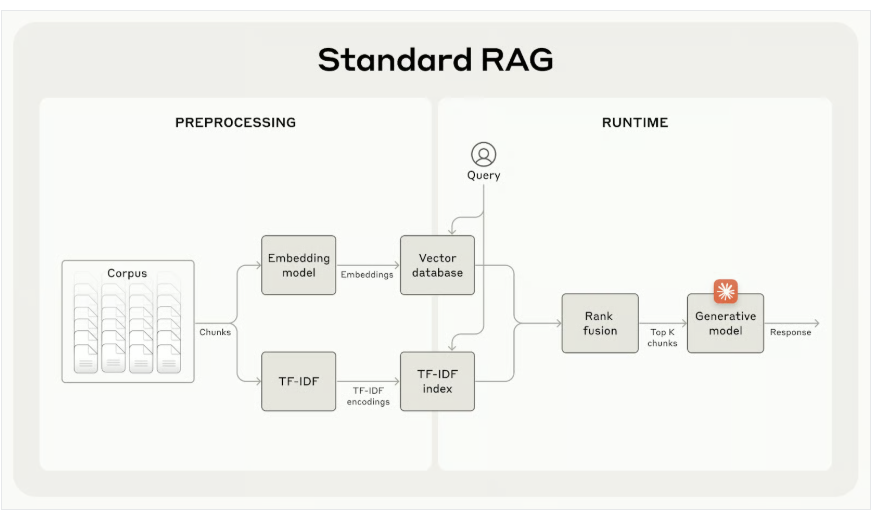 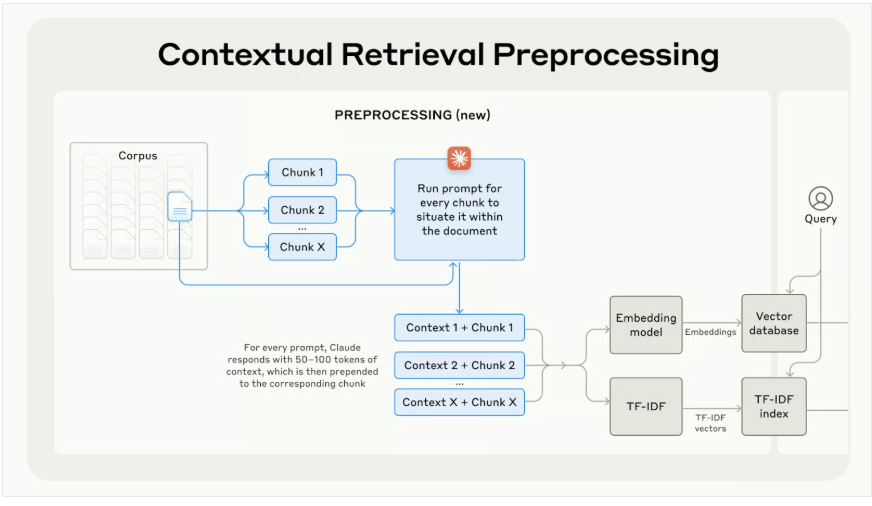

Now let's implement the proper Anthropic contextual retrieval method using LLMs to generate intelligent context.

In [ ]:
# Data
input_text = """Berlin is the capital and largest city of Germany, both by area and by population.
Its more than 3.85 million inhabitants make it the European Union's most populous city, as measured by population within city limits.
The city is also one of the states of Germany and is the third smallest state in the country in terms of area.
Paris is the capital and most populous city of France.
It is situated along the Seine River in the north-central part of the country.
The city has a population of over 2.1 million residents within its administrative limits, making it one of Europe's major population centers."""

chunks = [
    'Berlin is the capital and largest city of Germany, both by area and by population.',
    "Its more than 3.85 million inhabitants make it the European Union's most populous city.",
    'Paris is the capital and most populous city of France.',
    'It is situated along the Seine River in the north-central part of the country.'
]

# Setup
llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

prompt = PromptTemplate(
    input_variables=['document', 'chunk'],
    template="<document>{document}</document>\n<chunk>{chunk}</chunk>\nGive brief context for this chunk within the document:"
)

# Generate contextual chunks
contextual_chunks = []
for chunk in chunks:
    context = llm.invoke(prompt.format(document=input_text, chunk=chunk)).content
    contextual_chunk = f"{context} {chunk}"
    contextual_chunks.append(contextual_chunk)

# Create documents for ChromaDB
basic_docs = [Document(page_content=chunk, metadata={"type": "basic", "id": i}) 
              for i, chunk in enumerate(chunks)]

contextual_docs = [Document(page_content=chunk, metadata={"type": "contextual", "id": i}) 
                   for i, chunk in enumerate(contextual_chunks)]

# Create ChromaDB collections
basic_vectorstore = Chroma.from_documents(
    documents=basic_docs,
    embedding=embeddings,
    collection_name="basic_chunks"
)

contextual_vectorstore = Chroma.from_documents(
    documents=contextual_docs,
    embedding=embeddings,
    collection_name="contextual_chunks"
)

# Retrieval function
def compare_retrieval(query, k=2):
    print(f"Query: '{query}'\n")
    
    # Basic retrieval
    basic_results = basic_vectorstore.similarity_search_with_score(query, k=k)
    print("BASIC CHUNKS:")
    for i, (doc, score) in enumerate(basic_results, 1):
        print(f"{i}. Score: {score:.3f}")
        print(f"   {doc.page_content}\n")
    
    # Contextual retrieval
    contextual_results = contextual_vectorstore.similarity_search_with_score(query, k=k)
    print("CONTEXTUAL CHUNKS:")
    for i, (doc, score) in enumerate(contextual_results, 1):
        print(f"{i}. Score: {score:.3f}")
        print(f"   {doc.page_content}\n")
    
    print("="*60)

# Test queries
queries = [
    "What city is located on the Seine River?",
    "German city population statistics",
    "European Union populous cities"
]

print("=== CONTEXTUAL vs BASIC RETRIEVAL COMPARISON ===\n")
for query in queries:
    compare_retrieval(query)

# Show what contextual chunks look like
print("\n=== CONTEXTUAL CHUNKS PREVIEW ===")
for i, (basic, contextual) in enumerate(zip(chunks[:2], contextual_chunks[:2])):
    print(f"Chunk {i+1}:")
    print(f"Basic: {basic}")
    print(f"Contextual: {contextual}\n")

## Technique 3: Excluding Vector Search Outliers

Sometimes search returns results that technically match your query but are obviously irrelevant. These are "outliers" - results that sneak into your top-k but shouldn't be there.

### Two Main Approaches:
1. **Distance Thresholding**: Set a maximum distance - if results are too far away, exclude them
2. **Autocut**: Look for big jumps in similarity scores and cut off results after the jump

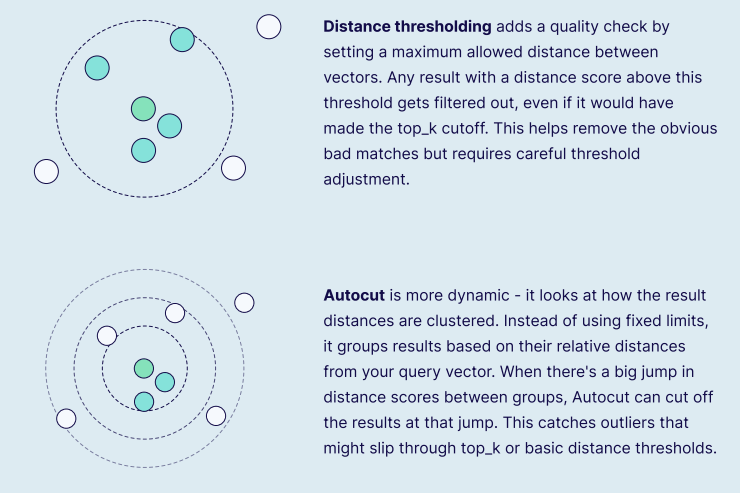

In [ ]:
# Setup (you'll need to initialize these)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Initialize ChromaDB client and collection
client = chromadb.Client()
collection = client.get_or_create_collection("test_collection")

# Sample data for testing
sample_docs = [
    "Python is a programming language",
    "Machine learning with Python",
    "Data science and analytics", 
    "The weather is nice today",
    "Cooking recipes for dinner"
]

# Add sample data to collection
for i, doc in enumerate(sample_docs):
    embedding = embeddings.embed_query(doc)
    collection.add(
        embeddings=[embedding],
        documents=[doc],
        metadatas=[{"id": i}],
        ids=[str(i)]
    )

def basic_search(query: str, n_results: int = 5):
    """Basic search function - returns all results with proper error handling"""
    query_embedding = embeddings.embed_query(query)
    
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )
    
    # Handle None results with default empty structure
    return {
        'documents': results.get('documents', [[]]),
        'distances': results.get('distances', [[]]),
        'metadatas': results.get('metadatas', [[]])
    }

def search_with_distance_threshold(query: str, max_distance: float = 0.7, n_results: int = 5):
    """Search and filter out results that are too far away"""
    query_embedding = embeddings.embed_query(query)
    
    # Get more results than we need
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )
    
    # Filter by distance threshold
    filtered_docs = []
    filtered_distances = []
    filtered_metadata = []
    
    # Check if we have results and handle None values
    documents = results.get('documents', [[]])
    distances = results.get('distances', [[]])
    metadatas = results.get('metadatas', [[]])
    
    if documents and documents[0] and distances and distances[0]:
        for i, distance in enumerate(distances[0]):
            if distance <= max_distance:  # Keep only close results
                filtered_docs.append(documents[0][i])
                filtered_distances.append(distance)
                if metadatas and metadatas[0] and i < len(metadatas[0]):
                    filtered_metadata.append(metadatas[0][i])
                else:
                    filtered_metadata.append({})
    
    return {
        'documents': [filtered_docs],
        'distances': [filtered_distances],
        'metadatas': [filtered_metadata]
    }

def search_with_autocut(query: str, n_results: int = 5, gap_threshold: float = 0.2):
    """Search and cut off results after a big jump in distances"""
    query_embedding = embeddings.embed_query(query)
    
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results
    )
    
    # Handle None results
    documents = results.get('documents', [[]])
    distances = results.get('distances', [[]])
    metadatas = results.get('metadatas', [[]])
    
    # Check if we have results
    if not distances or not distances[0]:
        return {
            'documents': [[]],
            'distances': [[]],
            'metadatas': [[]]
        }
    
    distances_list = distances[0]
    
    # Find where to cut based on gaps between consecutive distances
    cut_index = len(distances_list)  # Default: no cut
    
    for i in range(1, len(distances_list)):
        gap = distances_list[i] - distances_list[i-1]
        if gap > gap_threshold:  # Big jump found!
            cut_index = i
            break
    
    # Return only results before the cut
    return {
        'documents': [documents[0][:cut_index] if documents and documents[0] else []],
        'distances': [distances_list[:cut_index]],
        'metadatas': [metadatas[0][:cut_index] if metadatas and metadatas[0] else []]
    }

# Combined demo function
def contextual_search():
    """Run comprehensive search with detailed comparison and multiple queries"""
    # Second: Multiple query comparison
    test_queries = [
        "python programming",
        "weather forecast", 
        "machine learning algorithms",
        "cooking dinner recipes"
    ]
    
    print("MULTIPLE QUERY COMPARISON (Distance scores only)\n")
    
    for query in test_queries:
        print(f"Query: '{query}'")
        
        # Regular search
        regular = basic_search(query, n_results=3)
        regular_distances = regular['distances'][0] if regular['distances'] and regular['distances'][0] else []
        print(f"  Regular:   {[f'{d:.3f}' for d in regular_distances] if regular_distances else 'No results'}")
        
        # With threshold
        threshold = search_with_distance_threshold(query, max_distance=0.8, n_results=3)
        threshold_distances = threshold['distances'][0] if threshold['distances'] and threshold['distances'][0] else []
        print(f"  Threshold: {[f'{d:.3f}' for d in threshold_distances] if threshold_distances else 'No results'}")
        
        # With autocut
        autocut = search_with_autocut(query, gap_threshold=0.2, n_results=3)
        autocut_distances = autocut['distances'][0] if autocut['distances'] and autocut['distances'][0] else []
        print(f"  Autocut:   {[f'{d:.3f}' for d in autocut_distances] if autocut_distances else 'No results'}")
        
        print()

    print("="*60)
    print("SUMMARY:")
    print("- Regular: Returns all results regardless of relevance")
    print("- Threshold: Filters out results beyond distance threshold")
    print("- Autocut: Removes results after significant distance gaps")

# Run the comprehensive demo
if __name__ == "__main__":
    contextual_search()

## Technique 4: Hybrid Search

Hybrid search combines two different search methods:
1. **Vector search** (semantic): Understands meaning and context
2. **Keyword search** (BM25): Finds exact word matches

### Why Combine Them?
- Vector search: Great for "What's our financial performance?" → finds revenue docs
- Keyword search: Great for "Find docs mentioning 'API rate limiting'" → finds exact terms
- Together: Best of both worlds!

### The Alpha Parameter
- α = 1.0: Pure vector search
- α = 0.0: Pure keyword search  
- α = 0.7: 70% vector, 30% keyword (good balance)

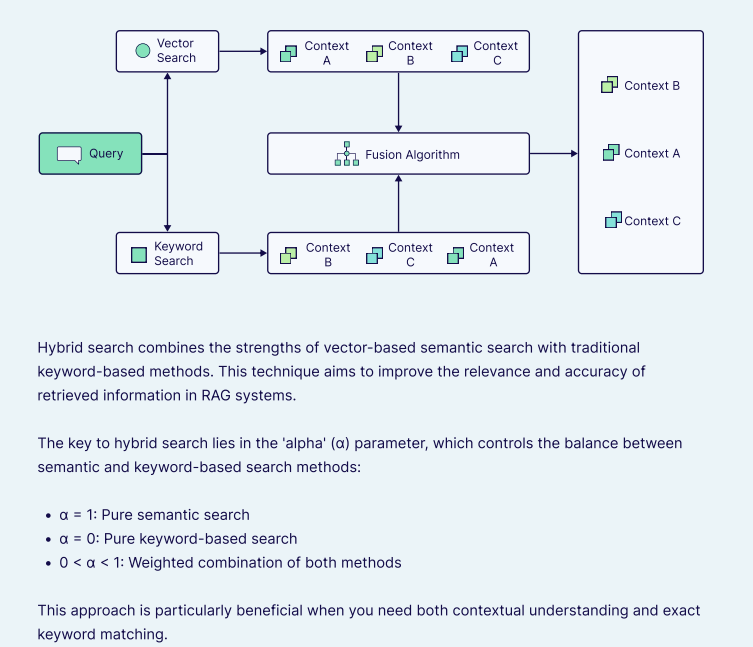

In [ ]:
# Sample documents (contexts A, B, C, etc.)
docs = [
    "API rate limiting prevents abuse by restricting requests per time period",  # Context A
    "Authentication ensures secure access to API endpoints using tokens",        # Context B
    "Database optimization improves query performance and reduces latency",      # Context C
    "Rate limiting strategies include token bucket and sliding window algorithms", # Context D
    "Machine learning models require careful training and validation data"       # Context E
]

doc_names = ["Context A", "Context B", "Context C", "Context D", "Context E"]

print("=== SETTING UP HYBRID SEARCH ===")

# Setup Vector Search
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
client = chromadb.Client()
collection = client.get_or_create_collection("fusion_demo")

for i, doc in enumerate(docs):
    embedding = embeddings.embed_query(doc)
    collection.add(
        embeddings=[embedding],
        documents=[doc],
        ids=[str(i)]
    )

# Setup Keyword Search
langchain_docs = [Document(page_content=doc) for doc in docs]
bm25_retriever = BM25Retriever.from_documents(langchain_docs)
bm25_retriever.k = len(docs)

print("✓ Both search methods ready\n")

def get_vector_ranking(query):
    """Get documents ranked by vector similarity"""
    try:
        query_embedding = embeddings.embed_query(query)
        results = collection.query(
            query_embeddings=[query_embedding],
            n_results=len(docs)
        )
        
        # Safe access with proper error handling
        documents = results.get('documents', [[]])
        if not documents or not documents[0]:
            return []
            
        # Return docs in order of similarity (best first)
        ranked_docs = documents[0]
        return ranked_docs
    except Exception as e:
        print(f"Vector search error: {e}")
        return []

def get_keyword_ranking(query):
    """Get documents ranked by keyword relevance"""
    try:
        results = bm25_retriever.invoke(query)
        # Return docs in order of BM25 relevance (best first)
        ranked_docs = [doc.page_content for doc in results]
        return ranked_docs
    except Exception as e:
        print(f"Keyword search error: {e}")
        return []

def reciprocal_rank_fusion(vector_ranking, keyword_ranking, k=60):
    """
    Fusion Algorithm: Reciprocal Rank Fusion (RRF)
    Popular method used in real hybrid search systems
    """
    doc_scores = {}
    
    # Add vector ranking scores
    for rank, doc in enumerate(vector_ranking):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += 1 / (k + rank + 1)  # RRF formula
    
    # Add keyword ranking scores
    for rank, doc in enumerate(keyword_ranking):
        if doc not in doc_scores:
            doc_scores[doc] = 0
        doc_scores[doc] += 1 / (k + rank + 1)  # RRF formula
    
    # Sort by combined score
    fused_ranking = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
    return fused_ranking

def show_rankings(query):
    """Show step-by-step how hybrid search works"""
    print(f"Query: '{query}'\n")
    
    # Step 1: Vector Search Rankings
    vector_ranking = get_vector_ranking(query)
    print("📊 VECTOR SEARCH RESULTS (by semantic similarity):")
    if vector_ranking:
        for i, doc in enumerate(vector_ranking[:3]):
            if doc in docs:  # Safety check
                doc_idx = docs.index(doc)
                print(f"  {i+1}. {doc_names[doc_idx]}: {doc[:50]}...")
    else:
        print("  No vector search results found")
    
    print()
    
    # Step 2: Keyword Search Rankings  
    keyword_ranking = get_keyword_ranking(query)
    print("🔍 KEYWORD SEARCH RESULTS (by word matching):")
    if keyword_ranking:
        for i, doc in enumerate(keyword_ranking[:3]):
            if doc in docs:  # Safety check
                doc_idx = docs.index(doc)
                print(f"  {i+1}. {doc_names[doc_idx]}: {doc[:50]}...")
    else:
        print("  No keyword search results found")
    
    print()
    
    # Step 3: Fusion Algorithm
    if vector_ranking or keyword_ranking:
        fused_results = reciprocal_rank_fusion(vector_ranking, keyword_ranking)
        print("⚡ FUSION ALGORITHM RESULTS (combined & reranked):")
        for i, (doc, score) in enumerate(fused_results[:3]):
            if doc in docs:  # Safety check
                doc_idx = docs.index(doc)
                print(f"  {i+1}. {doc_names[doc_idx]} (Score: {score:.3f})")
                print(f"     {doc[:50]}...")
    else:
        print("⚡ FUSION ALGORITHM RESULTS: No results to combine")
    
    print("\n" + "="*60 + "\n")

def main_demo():
    """Run the complete hybrid search demo"""
    print("=== HYBRID SEARCH DEMO (Following the Diagram) ===\n")
    
    # Test with different types of queries
    queries = [
        "API rate limiting",           # Should match Context A well
        "secure authentication",       # Should match Context B well  
        "performance optimization"     # Should match Context C well
    ]
    
    for query in queries:
        show_rankings(query)

if __name__ == "__main__":
    main_demo()

## Key Takeaways and Best Practices

Congratulations! You've learned how to build a much smarter retrieval system. Here's what we covered:

### What We Learned

1. **Metadata Filtering**: Use document properties to narrow search scope
   - Best for: Queries where you know the document type or source
   - Example: "Show me only financial reports from Q3"

2. **Contextual Retrieval**: Add context to chunks before embedding
   - Best for: Improving overall search accuracy
   - Benefit: 35-49% reduction in retrieval failures

3. **Outlier Exclusion**: Remove obviously irrelevant results
   - Best for: Queries that might return some very poor matches
   - Methods: Distance thresholding and autocut

4. **Hybrid Search**: Combine vector and keyword search
   - Best for: Getting both semantic understanding and exact matches
   - Tune alpha based on your query types

### When to Use What

- **Use metadata filtering when**: You have structured documents with clear categories
- **Use contextual retrieval when**: Your chunks lose important context when split
- **Use outlier removal when**: You get obviously irrelevant results in your top-k
- **Use hybrid search when**: You need both semantic and exact keyword matching

### Production Tips

1. **Start simple**: Implement one technique at a time
2. **Measure everything**: Track search quality before and after changes
3. **Tune for your data**: Different datasets need different parameters
4. **Consider costs**: Contextual retrieval increases embedding costs
5. **Monitor performance**: Search latency vs accuracy trade-offs

### Next Steps

- Try these techniques on your own data
- Experiment with different parameter values
- Consider adding reranking as a post-processing step
- Build evaluation metrics to measure improvement

Happy retrieving!